# [VQ-VAE](https://arxiv.org/abs/1711.00937) for audio in PyTorch

This notebook is based on 
https://github.com/zalandoresearch/pytorch-vq-vae

## Introduction

Variational Auto Encoders (VAEs) can be thought of as what all but the last layer of a neural network is doing, namely feature extraction or seperating out the data. Thus given some data we can think of using a neural network for representation generation. 

Recall that the goal of a generative model is to estimate the probability distribution of high dimensional data such as images, videos, audio or even text by learning the underlying structure in the data as well as the dependencies between the different elements of the data. This is very useful since we can then use this representation to generate new data with similar properties. This way we can also learn useful features from the data in an unsupervised fashion.

The VQ-VAE uses a discrete latent representation mostly because many important real-world objects are discrete. For example in images we might have categories like "Cat", "Car", etc. and it might not make sense to interpolate between these categories. Discrete representations are also easier to model since each category has a single value whereas if we had a continous latent space then we will need to normalize this density function and learn the dependencies between the different variables which could be very complex.

### Code

I have followed the code from the TensorFlow implementation by the author which you can find here [vqvae.py](https://github.com/deepmind/sonnet/blob/master/sonnet/python/modules/nets/vqvae.py) and [vqvae_example.ipynb](https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb). 

Another PyTorch implementation is found at [pytorch-vqvae](https://github.com/ritheshkumar95/pytorch-vqvae).


## Basic Idea

We start by defining a latent embedding space of dimension `[K, D]` where `K` are the number of embeddings and `D` is the dimensionality of each latent embeddng vector $e_i$.

The model will take in batches of waveforms, of size 16126 for our example, and pass it through a ConvNet encoder producing some output, where we make sure the channels are the same as the dimensionality of the latent embedding vectors. To calculate the discrete latent variable we find the nearest embedding vector and output it's index. 

The input to the decoder is the embedding vector corresponding to the index which is passed through the decoder to produce the reconstructed audio. 

Since the nearest neighbour lookup has no real gradient in the backward pass we simply pass the gradients from the decoder to the encoder  unaltered. The intuition is that since the output representation of the encoder and the input to the decoder share the same `D` channel dimensional space, the gradients contain useful information for how the encoder has to change its output to lower the reconstruction loss.

## Loss

The total loss is composed of three components:

1. reconstruction loss which optimizes the decoder and encoder
1. due to the fact that gradients bypass the embedding, we use a dictionary learning algorithm  which uses an $l_2$  error to move the embedding vectors $e_i$ towards the encoder output
1. also since the volume of the embedding space is dimensionless, it can grow arbirtarily if the embeddings $e_i$ do not train as fast as  the encoder parameters, and thus we add a commitment loss to make sure that the encoder commits to an embedding

In [1]:
import os
import subprocess

import math

import matplotlib.pyplot as plt
import numpy as np
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler
import torch.optim as optim
from torch.distributions import Multinomial

from audio_loader import VCTK
from wavenet_vocoder.wavenet import WaveNet
from wavenet_vocoder.wavenet import receptive_field_size
#from vq import VectorQuantizerEMA

In [2]:
device = torch.device("cuda")
device

device(type='cuda')

In [3]:
class SubsetSequentialSampler(Sampler):
    r"""Samples elements from a given list of indices sequentially, always in the same order.

    Arguments:
        indices (sequence): a sequence of indices
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return iter(self.indices)
    
    def __len__(self):
        return len(self.indices)

In [4]:
#TO DO: check that weight gets updated
class VectorQuantizerEMA(nn.Module):
    """We will also implement a slightly modified version  which will use exponential moving averages
    to update the embedding vectors instead of an auxillary loss.
    This has the advantage that the embedding updates are independent of the choice of optimizer 
    for the encoder, decoder and other parts of the architecture.
    For most experiments the EMA version trains faster than the non-EMA version."""
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
#        self._embedding.weight.data.normal_()
        self._embedding.weight.data = torch.Tensor([0])
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCL -> BLC
        inputs = inputs.permute(0, 2, 1).contiguous()
        input_shape = inputs.shape
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)     #[BL, C]
        if (self._embedding.weight.data == 0).all():
            self._embedding.weight.data = flat_input[-self._num_embeddings:].detach()
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t())) #[BL, num_embeddings]
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) #[BL, 1]
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings).to(device)# [BL, num_embeddings]
        encodings.scatter_(1, encoding_indices, 1)
        #print(encodings.shape) [250, 512]
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            #print(self._ema_cluster_size.shape) [512]
            n = torch.sum(self._ema_cluster_size)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Quantize and unflatten
        #encodings.shape = [BL, num_embeddings] , weight.shape=[num_embeddings, C]
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        q_latent_loss = torch.mean((quantized - inputs.detach())**2)
#        print(q_latent_loss.item(), 0.25 * e_latent_loss.item())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        # convert quantized from BLC -> BCL
        return loss, quantized.permute(0, 2, 1).contiguous(), perplexity


In [5]:
# embedding_dim=1
# num_embeddings=2
# ema = VectorQuantizerEMA(embedding_dim=embedding_dim,
#                         num_embeddings=num_embeddings,
#                         commitment_cost=0.5,
#                         decay=0.99,
#                         device=device)
  
# ema.eval()
# print("is training", ema.training)
# inputs_np = np.random.randn(20, embedding_dim).astype(np.float32)
# print("inputs", inputs_np)
# inputs = torch.Tensor(inputs_np.reshape(1,embedding_dim,20))

# loss, vq_output, perplexity = ema(inputs)
# print("loss", loss)
# print("output", vq_output)
# # Output shape is correct
# assert vq_output.shape == inputs.shape
    
# #assert ema._embedding.weight.detach().numpy().shape == [embedding_dim, num_embeddings]
# # Check that each input was assigned to the embedding it is closest to.
# embeddings_np = ema._embedding.weight.detach().numpy().T
# distances = ((inputs_np**2).sum(axis=1, keepdims=True) -
#              2 * np.dot(inputs_np, embeddings_np) +
#              (embeddings_np**2).sum(axis=0, keepdims=True))
# closest_index = np.argmax(-distances, axis=1)

# print(closest_index)

## Encoder & Decoder Architecture

In [6]:
class Encoder(nn.Module):
    """Audio encoder
    The vq-vae paper says that the encoder has 6 strided convolutions with stride 2 and window-size 4.
    The number of channels and a nonlinearity is not specified in the paper. 
    I tried using ReLU, it didn't work.
    Now I try using tanh, hoping that this will keep my encoded values within the neighborhood of 0,
    so they do not drift too far away from encoding vectors.
    """
    def __init__(self, encoding_channels, in_channels=256):
        super(Encoder,self).__init__()
        self._num_layers = 2 * len(encoding_channels)
        self._layers = nn.ModuleList()
        for out_channels in encoding_channels:
            self._layers.append(nn.Conv1d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    stride=2,
                                    kernel_size=4,
                                    padding=0, 
                                        ))
            self._layers.append(nn.Tanh())
            in_channels = out_channels
        
    def forward(self, x):
        for i in range(self._num_layers):
            x = self._layers[i](x)
        return x

In [7]:
class Model(nn.Module):
    def __init__(self,
                 encoding_channels,
                 num_embeddings, 
                 embedding_dim,
                 commitment_cost, 
                 layers,
                 stacks,
                 kernel_size,
                 decay=0):
        super(Model, self).__init__()       
        self._encoder = Encoder(encoding_channels=encoding_channels)
        #I tried adding batch normalization here, because:
        #the distribution of encoded values needs to be similar to the distribution of embedding vectors
        #otherwise we'll see "posterior collapse": all values will be assigned to the same embedding vector,
        #and stay that way (because vectors which do not get assigned anything do not get updated).
        #Batch normalization is a way to fix that. But it didn't work: model
        #reproduced voice correctly, but the words were completely wrong.
        #self._batch_norm = nn.BatchNorm1d(1)
        if decay > 0.0:
#             self._vq_vae = EMVectorQuantizerEMA(num_embeddings, embedding_dim, 
#                                               commitment_cost, decay, 100)
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                               commitment_cost, decay)

        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = WaveNet(device, out_channels=256, #dimension of ohe mu-quantized signal
                                layers=layers, #like in original WaveNet
                                stacks=stacks,
                                residual_channels=512,
                                gate_channels=512,
                                skip_out_channels=512,
                                kernel_size=kernel_size, 
                                dropout=1 - 0.95,
                                cin_channels=embedding_dim, #local conditioning channels - on encoder output
                                gin_channels=109, #global conditioning channels - on speaker_id
                                n_speakers=109,
                                weight_normalization=False, 
                                upsample_conditional_features=True, 
                                decoding_channels=encoding_channels[::-1],
                                use_speaker_embedding=False
                               )
        self.recon_loss = torch.nn.CrossEntropyLoss()
        self.receptive_field = receptive_field_size(total_layers=layers, num_cycles=stacks, kernel_size=kernel_size)
#        self.mean = None
#        self.std = None
    def forward(self, x):
        audio, target, speaker_id = x
        assert len(audio.shape) == 3 # B x C x L 
        assert audio.shape[1] == 256
        z = self._encoder(audio)
        #normalize output - subtract mean, divide by standard deviation
        #without this, perplexity goes to 1 almost instantly
#         if self.mean is None:
#             self.mean = z.mean().detach()
#         if self.std is None:
#              self.std = z.std().detach()
#        z = z - self.mean
#        z = z / self.std
        
        vq_loss, quantized, perplexity = self._vq_vae(z)
#        assert z.shape == quantized.shape
#        print("audio.shape", audio.shape)
#        print("quantized.shape", quantized.shape)
        x_recon = self._decoder(audio, quantized, speaker_id, softmax=False)
        x_recon = x_recon[:, :, self.receptive_field:-1]
        recon_loss_value = self.recon_loss(x_recon, target[:, 1:])
        loss = recon_loss_value + vq_loss
        
        return loss, recon_loss_value, x_recon, perplexity

# Train

In [8]:
num_training_updates = 39818
#vector quantizer parameters:
embedding_dim = 64 #dimension of each vector
encoding_channels = [512,512,512,512,512,embedding_dim]
num_embeddings = 512 #number of vectors
commitment_cost = 0.25

#wavenet parameters:
kernel_size=2
total_layers=30
num_cycles=3


decay = 0.99
#decay = 0

learning_rate = 3e-4
batch_size=1

In [9]:
receptive_field = receptive_field_size(total_layers=total_layers, num_cycles=num_cycles, kernel_size=kernel_size)
print(receptive_field)

3070


## Load data

In [10]:
from audio_loader import VCTK

In [11]:
model = Model(num_embeddings=num_embeddings,
              encoding_channels=encoding_channels,
              embedding_dim=embedding_dim, 
              commitment_cost=commitment_cost, 
              layers=total_layers,
              stacks=num_cycles,
              kernel_size=kernel_size,
              decay=decay).to(device)

In [12]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           mode='min', 
                                                           factor=0.2, 
                                                           patience=50000, 
                                                           verbose=True, 
                                                           threshold=0.0001,
                                                           threshold_mode='rel',
                                                           cooldown=0, 
                                                           min_lr=0, 
                                                           eps=1e-08)

In [13]:
data = VCTK("/gpfs/gpfs0/a.phan/Vika_voice_conversion/VCTK", receptive_field=receptive_field)
print(len(data))
indices = np.arange(len(data))
test_size = len(data) // 10

train_indices = indices[:-test_size]
test_indices = indices[-test_size:]

training_loader = DataLoader(data, 
                           batch_size=1,
                           shuffle=False, 
                           num_workers=1,
                           sampler=SubsetSequentialSampler(train_indices))

validation_loader = DataLoader(data, 
                           batch_size=1,
                           shuffle=False, 
                           num_workers=1,
                           sampler=SubsetSequentialSampler(test_indices))

44242


In [14]:
len(train_indices), len(test_indices)

(39818, 4424)

In [15]:
model.load_state_dict(torch.load("mymodel"))
optimizer.load_state_dict(torch.load("myoptim"))

RuntimeError: Error(s) in loading state_dict for Model:
	size mismatch for _vq_vae._embedding.weight: copying a param of torch.Size([1]) from checkpoint, where the shape is torch.Size([512, 64]) in current model.

In [ ]:
model.train()
#train_res_recon_error = []
#train_res_perplexity = []
# with open("errors", "rb") as file:
#     train_res_recon_error, train_res_perplexity = pickle.load(file)
num_epochs = 5
for epoch in range(num_epochs):
    iterator = iter(training_loader)
#     datas0 = []
#     datas1 = []
#     datas2 = []
    for i, data_train in enumerate(iterator):
        
        data_train = [data_train[0].to(device),
                     data_train[1].to(device),
                     data_train[2].to(device)
                     ]
#         datas0.append(data_train[0])
#         datas1.append(data_train[1])
#         datas2.append(data_train[2])
#         if (i+1) % batch_size == 0:
#             data = [torch.cat(datas0).to(device),
#                    torch.cat(datas1).to(device),
#                    torch.cat(datas2).to(device)]
        optimizer.zero_grad()

        loss, recon_error, data_recon, perplexity = model(data_train)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        train_res_recon_error.append(recon_error.item())
        train_res_perplexity.append(perplexity.item())

        if (i+1) % (10 * batch_size) == 0:
            print('%d iterations' % (i+1))
            print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
            print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
            print()

10 iterations
recon_error: 1.781
perplexity: 133.601

20 iterations
recon_error: 1.806
perplexity: 134.033

30 iterations
recon_error: 1.804
perplexity: 133.779

40 iterations
recon_error: 1.804
perplexity: 133.785

50 iterations
recon_error: 1.802
perplexity: 133.120

60 iterations
recon_error: 1.782
perplexity: 133.333

70 iterations
recon_error: 1.779
perplexity: 132.958

80 iterations
recon_error: 1.802
perplexity: 132.836

90 iterations
recon_error: 1.812
perplexity: 132.886

100 iterations
recon_error: 1.785
perplexity: 132.943

110 iterations
recon_error: 1.745
perplexity: 132.976

120 iterations
recon_error: 1.729
perplexity: 132.881

130 iterations
recon_error: 1.761
perplexity: 133.668

140 iterations
recon_error: 1.792
perplexity: 133.633

150 iterations
recon_error: 1.816
perplexity: 134.012

160 iterations
recon_error: 1.800
perplexity: 133.710

170 iterations
recon_error: 1.764
perplexity: 134.415

180 iterations
recon_error: 1.770
perplexity: 134.808

190 iterations
reco

1490 iterations
recon_error: 1.614
perplexity: 132.255

1500 iterations
recon_error: 1.677
perplexity: 133.014

1510 iterations
recon_error: 1.639
perplexity: 133.545

1520 iterations
recon_error: 1.680
perplexity: 132.470

1530 iterations
recon_error: 1.670
perplexity: 132.005

1540 iterations
recon_error: 1.673
perplexity: 132.808

1550 iterations
recon_error: 1.681
perplexity: 132.976

1560 iterations
recon_error: 1.665
perplexity: 133.085

1570 iterations
recon_error: 1.692
perplexity: 132.432

1580 iterations
recon_error: 1.733
perplexity: 132.821

1590 iterations
recon_error: 1.732
perplexity: 133.077

1600 iterations
recon_error: 1.697
perplexity: 132.923

1610 iterations
recon_error: 1.737
perplexity: 133.000

1620 iterations
recon_error: 1.752
perplexity: 132.634

1630 iterations
recon_error: 1.738
perplexity: 133.295

1640 iterations
recon_error: 1.724
perplexity: 132.575

1650 iterations
recon_error: 1.724
perplexity: 132.587

1660 iterations
recon_error: 1.728
perplexity: 1

2960 iterations
recon_error: 1.742
perplexity: 134.596

2970 iterations
recon_error: 1.785
perplexity: 134.143

2980 iterations
recon_error: 1.787
perplexity: 134.236

2990 iterations
recon_error: 1.776
perplexity: 133.459

3000 iterations
recon_error: 1.800
perplexity: 133.504

3010 iterations
recon_error: 1.765
perplexity: 133.739

3020 iterations
recon_error: 1.767
perplexity: 133.632

3030 iterations
recon_error: 1.772
perplexity: 133.710

3040 iterations
recon_error: 1.792
perplexity: 133.936

3050 iterations
recon_error: 1.842
perplexity: 133.545

3060 iterations
recon_error: 1.836
perplexity: 133.380

3070 iterations
recon_error: 1.830
perplexity: 133.500

3080 iterations
recon_error: 1.783
perplexity: 133.481

3090 iterations
recon_error: 1.787
perplexity: 133.359

3100 iterations
recon_error: 1.810
perplexity: 131.976

3110 iterations
recon_error: 1.807
perplexity: 131.648

3120 iterations
recon_error: 1.821
perplexity: 131.393

3130 iterations
recon_error: 1.809
perplexity: 1

4720 iterations
recon_error: 1.807
perplexity: 132.503

4730 iterations
recon_error: 1.778
perplexity: 132.768

4740 iterations
recon_error: 1.743
perplexity: 132.498

4750 iterations
recon_error: 1.723
perplexity: 132.081

4760 iterations
recon_error: 1.692
perplexity: 132.471

4770 iterations
recon_error: 1.681
perplexity: 132.261

4780 iterations
recon_error: 1.693
perplexity: 132.178

4790 iterations
recon_error: 1.736
perplexity: 132.117

4800 iterations
recon_error: 1.659
perplexity: 133.201

4810 iterations
recon_error: 1.648
perplexity: 133.191

4820 iterations
recon_error: 1.643
perplexity: 133.839

4830 iterations
recon_error: 1.653
perplexity: 133.024

4840 iterations
recon_error: 1.658
perplexity: 133.841

4850 iterations
recon_error: 1.694
perplexity: 133.284

4860 iterations
recon_error: 1.703
perplexity: 133.314

4870 iterations
recon_error: 1.681
perplexity: 132.498

4880 iterations
recon_error: 1.654
perplexity: 131.947

4890 iterations
recon_error: 1.628
perplexity: 1

6190 iterations
recon_error: 1.607
perplexity: 134.314

6200 iterations
recon_error: 1.598
perplexity: 133.982

6210 iterations
recon_error: 1.615
perplexity: 134.000

6220 iterations
recon_error: 1.613
perplexity: 133.639

6230 iterations
recon_error: 1.580
perplexity: 132.979

6240 iterations
recon_error: 1.560
perplexity: 132.787

6250 iterations
recon_error: 1.562
perplexity: 132.893

6260 iterations
recon_error: 1.557
perplexity: 133.187

6270 iterations
recon_error: 1.562
perplexity: 132.962

6280 iterations
recon_error: 1.538
perplexity: 133.926

6290 iterations
recon_error: 1.568
perplexity: 133.965

6300 iterations
recon_error: 1.609
perplexity: 134.483

6310 iterations
recon_error: 1.600
perplexity: 134.955

6320 iterations
recon_error: 1.598
perplexity: 134.726

6330 iterations
recon_error: 1.635
perplexity: 134.646

6340 iterations
recon_error: 1.654
perplexity: 134.839

6350 iterations
recon_error: 1.643
perplexity: 134.804

6360 iterations
recon_error: 1.679
perplexity: 1

In [58]:
from scipy.signal import convolve
smooth_loss = convolve(train_res_recon_error, [0.001] * 1000, mode='valid')

Text(0.5, 0, 'iteration')

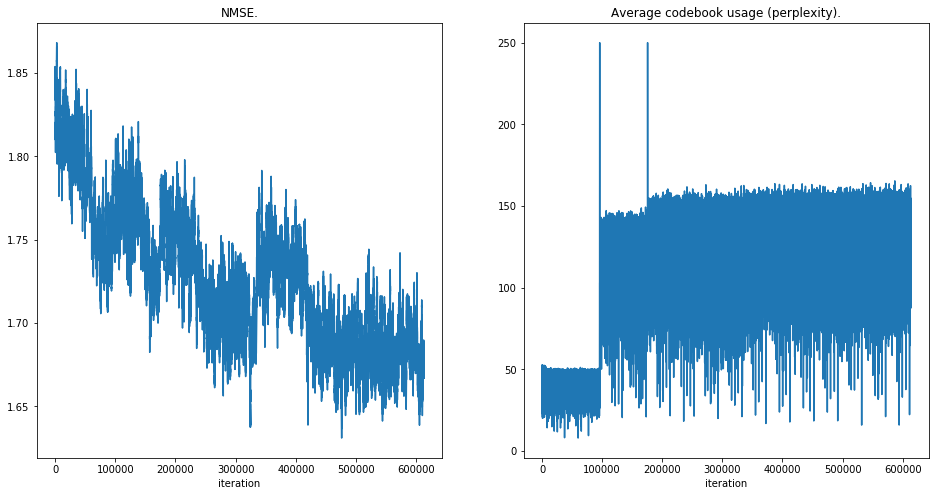

In [59]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(smooth_loss)
#ax.set_yscale('log')
ax.set_title('NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity)
ax.set_title('Average codebook usage (perplexity).')
ax.set_xlabel('iteration')
#I accidentally removed loss for first 20000 iterations or so.

## View Reconstructions

In [60]:
torch.save(model.state_dict(), "mymodel")
torch.save(optimizer.state_dict(), "myoptim")

In [57]:
import pickle
with open("errors", "wb") as file:
    pickle.dump([train_res_recon_error, train_res_perplexity], file)

In [ ]:
#test encoding-decoding
# import librosa
# audio, sr = librosa.load("../VCTK/wav48/p225/p225_001.wav")
# normalized = librosa.util.normalize(audio) #divide max(abs(audio))
# mu_x = data.mu_law_encode(normalized, 256)
# bins = np.linspace(-1, 1, 256)
# quantized = np.digitize(mu_x, bins) - 1
# plt.plot(quantized[:100])
# plt.show()

# mu_rec = (quantized + 1) / 128 - 1
# plt.plot(mu_rec[:1000], color='red')
# plt.plot(mu_x[:1000], color='blue')
# plt.show()

# decoded = data.mu_law_decode(mu_rec, 256)
# plt.plot(normalized[:1000], color='blue')
# plt.plot(decoded[:1000], color='red')
# plt.show()

In [61]:
model.eval()

data_train = data[train_indices[8]]
data_train = [data_train[0].to(device).unsqueeze(0), 
                  data_train[1].to(device).unsqueeze(0),
                  data_train[2].to(device).unsqueeze(0)]
valid_originals = data_train[0]
speaker_id = data_train[2]

with torch.no_grad():
    encoded = model._encoder(valid_originals)

    _, valid_quantize, _ = model._vq_vae(encoded)
    #valid_reconstructions = model._decoder(valid_originals, valid_quantize, speaker_id) - this one works fine
    valid_reconstructions = model._decoder.incremental_forward(valid_originals[:,:,0:1], 
                                                               valid_quantize, 
                                                               speaker_id, 
                                                               T=16126)

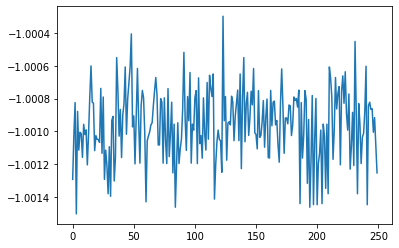

In [62]:
plt.plot(valid_quantize[:,0,:].detach().cpu().numpy().ravel())
plt.show()

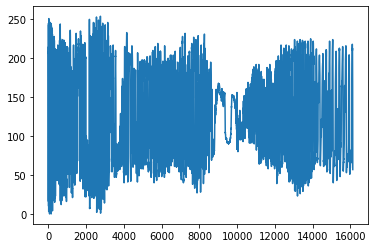

In [63]:
recon = valid_reconstructions.squeeze().argmax(dim=0).detach().cpu().numpy()
plt.plot(recon)
plt.show()

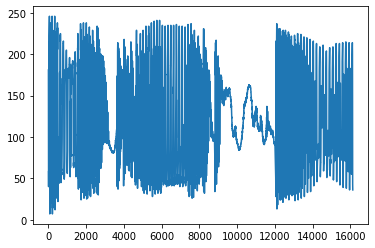

In [64]:
orig = valid_originals.squeeze().argmax(dim=0).detach().cpu().numpy()
#plt.plot(valid_quantize.detach().numpy().ravel())
plt.plot(orig)
plt.show()

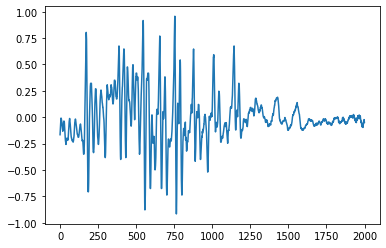

In [65]:
recon = valid_reconstructions.squeeze().argmax(dim=0).detach().cpu().numpy()
mu_encoded = (recon + 1) / 128 - 1
mu_decoded = data.mu_law_decode(mu_encoded, mu=256)
plt.plot(mu_decoded[2000:4000])
plt.show()

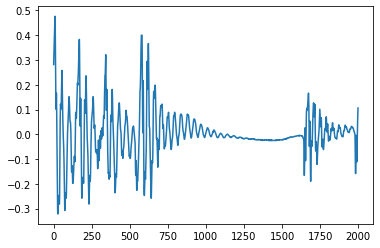

In [66]:
recon = valid_originals.squeeze().argmax(dim=0).detach().cpu().numpy()
mu_encoded_orig = (recon + 1) / 128 - 1
mu_decoded_orig = data.mu_law_decode(mu_encoded_orig, mu=256)
plt.plot(mu_decoded_orig[2000:4000])
plt.show()

In [67]:
from IPython.display import Audio, display

In [68]:
display(Audio(mu_decoded, rate=22050))

In [69]:
display(Audio(mu_decoded_orig, rate=22050))

## View Embedding

In [70]:
embeddings = model._vq_vae._embedding.weight.data.cpu()
embeddings
# plt.plot(sorted(embeddings))
# plt.show()

tensor([[-1.0009e+00, -6.0677e-01, -3.6123e-01,  ..., -5.8606e-01,
          1.0009e+00,  6.7920e-01],
        [-1.0010e+00, -1.0740e-01,  1.2709e-01,  ..., -5.0707e-01,
          1.0010e+00,  3.8139e-01],
        [-1.0011e+00,  6.0525e-01, -4.4774e-01,  ..., -7.1620e-01,
          1.0011e+00,  1.9496e-01],
        ...,
        [ 7.0209e-41, -7.0209e-41, -7.0209e-41,  ...,  7.0209e-41,
         -7.0209e-41, -7.0209e-41],
        [-7.0209e-41,  7.0209e-41,  7.0209e-41,  ...,  7.0209e-41,
          7.0209e-41, -7.0209e-41],
        [ 7.0209e-41, -7.0209e-41, -7.0209e-41,  ...,  7.0209e-41,
          7.0209e-41, -7.0209e-41]])

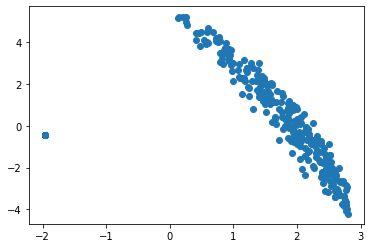

In [75]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
y = pca.fit_transform(embeddings)
plt.scatter(y[:,0],y[:,1])
plt.show()